<a href="https://colab.research.google.com/github/lmntrx-sys/AlphaZero/blob/main/Alpha_Zero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
np.__version__
import tensorflow as tf
from tensorflow.keras import layers
tf.__version__
from tqdm.notebook import trange

import random


# set seed
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
else:
    print("No GPU detected. Running on CPU.")



Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs


In [3]:
# Create the Gaming environment
class TicTacToe:
  def __init__(self) -> None:
    self.row_count = 3
    self.column_count = 3
    self.action_space = np.array([i for i in range(self.row_count * self.column_count)])

  # Initialize the previous states for reference
  def get_initial_state(self):
    return np.zeros((self.row_count, self.column_count))

  # Get the next states
  def get_next_state(self, state, action, player):
    row = action // self.column_count
    column = action % self.column_count
    state[row, column] = player
    return state

  def get_valid_moves(self, state):
    return (state.reshape(-1) == 0).astype(np.uint8)

  # Check win
  def check_game_over(self, state, action):
    if action == None:
      return False

    row = action // self.column_count
    column = action % self.column_count
    player = state[row, column]
    return (np.sum(state[row, :]) == player * self.column_count
            or np.sum(state[:, column]) == player * self.row_count
            or np.sum(np.diag(state)) == player * self.row_count
            or np.sum(np.diag(np.flip(state, axis=0))) == player * self.row_count)

  def get_game_value(self, state, action):
    if np.sum(self.check_game_over(state, action)):
      return 1, True
    if np.sum(self.get_valid_moves(state)) == 0:
      return 0, True
    return 0, False

  def get_opponent(self, value):
    return -player

  def get_encoded_state(self, state):
    encoded_state = np.stack(
        (state == -1, state == 0, state == 1)
    ).astype(np.float32)
    return encoded_state

  def change_perspective(self, state, player):
    return state * player

  def get_opponent_value(self, value):
    return -value

In [4]:
env = TicTacToe()
state = env.get_initial_state()
state = env.get_next_state(state, 0, -1)
state = env.get_next_state(state, 1, 1)
print(state)
encoded_state = env.get_encoded_state(state)
print(encoded_state)

tensor_state = tf.convert_to_tensor(encoded_state)
tensor_state = tf.expand_dims(tensor_state, axis=0)
print(tensor_state)

[[-1.  1.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
[[[1. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[0. 1. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
tf.Tensor(
[[[[1. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[0. 1. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]], shape=(1, 3, 3, 3), dtype=float32)


In [5]:
class Node:
  def __init__(self, game, args, state, parent=None, action_from_parent_taken=None, possible_action=None, prior=0):
    self.game = game
    self.args = args
    self.state = state
    self.parent = parent
    self.prior = prior
    self.action_from_parent_taken = action_from_parent_taken
    self.children = []
    self.visit_count = 0
    self.value_sum = 0

  def select(self):
    best_child = None
    best_uct_value = -np.inf

    for child in self.children:
      uct_value = self.get_uct_value(child)

      if uct_value > best_uct_value:
        beat_uct_value = uct_value
        best_child = child
    return best_child

  def get_uct_value(self, child):
    if child.visit_count == 0:
      q_value = 0
    else:
      q_value = 1 - ((child.value_sum / child.visit_count) + 1) / 2
    exploration_term = self.args['C'] * np.sqrt(np.log(self.visit_count) / (child.visit_count + 1)) *child.prior
    return q_value + exploration_term

  def expand_node(self, policy):
    for action, prob in enumerate(policy):
      if prob > 0:
        child_state = self.state.copy()
        child_state = self.game.get_next_state(state=child_state, action=action, player=1)
        child_state = self.game.change_perspective(child_state, player=-1)

        child = Node(self.game, self.args, child_state, self, action, prob)
        self.children.append(child)
    return child

  def add_child(self, child_node):
    self.children[child_node.action_from_parent_taken] = child_node

  def is_fully_expanded(self):
    return len(self.children) > 0

  def backpropagate(self, value):
    self.value_sum += value
    self.visit_count += 1

    value = self.game.get_opponent_value(value)
    if self.parent is not None:
      self.parent.backpropagate(value)

  def best_child(self, c=0):
    best_visit_count = -1
    best_action = None
    for child in self.children:
      if self.children[child].visit_count > best_visit_count:
        best_visit_count = self.children[child].visit_count
        best_action = child
    return best_action



In [6]:
class MCTS:
  def __init__(self, game, args, model):
    self.game = game
    self.args = args
    self.model = model


  def search(self, state):
    root = Node(self.game, self.args, state)

    for search in range(self.args['num_searches']):
      node = root

      while node.is_fully_expanded():
        node = node.select()

      value, is_terminal = self.game.get_game_value(node.state, node.action_from_parent_taken)
      value = self.game.get_opponent_value(value)

      if not is_terminal:
        policy, value = self.model(
            tf.constant(tf.expand_dims(self.game.get_encoded_state(node.state), axis=0))
        )
        policy = tf.nn.softmax(policy, axis=1).numpy()[0]

        valid_moves = self.game.get_valid_moves(node.state)
        policy *= valid_moves
        policy /= np.sum(policy)

        value = value.numpy()

        node.expand_node(policy)

      node.backpropagate(value)


    action_probs = np.zeros(shape=(3 * 3))
    for child in root.children:
      action_probs[child.action_from_parent_taken] = child.visit_count # <-----
    action_probs /= np.sum(action_probs)
    return action_probs


In [7]:
def residual_block(x, filters, stride=1):
  res = x
  x = layers.Conv2D(filters, 3, strides=stride, padding='same', activation='relu')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
  x = layers.BatchNormalization()(x)

  if stride > 1 or x.shape[-1] != res.shape[-1]:
    res = layers.Conv2D(filters, 1, strides=stride, padding='same')(res)
    res = layers.BatchNormalization()(res)

  x = layers.Add()([x, res])
  x = layers.ReLU()(x)
  return x

def policy_head(x, actions):
  x = layers.Flatten()(x)
  x = layers.Dense(actions, activation='softmax')(x)
  return x

def value_head(x):
  x = layers.Flatten()(x)
  x = layers.Dense(1, activation='tanh')(x)
  return x

def resnet_tictactoe_policy(input_shape=(3, 3, 3), num_actions=9):
  input_tensor = tf.keras.Input(shape=input_shape)
  x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_tensor)
  x = layers.BatchNormalization()(x)

  # Add a few residual blocks
  x = residual_block(x, 32)
  x = residual_block(x, 32)
  x = residual_block(x, 32)

  # Output layer for policy (action probabilities)
  policy = policy_head(x, num_actions)
  values = value_head(x)

  model = tf.keras.Model(inputs=input_tensor, outputs=[policy, values])

  return model

policy_model = resnet_tictactoe_policy()
policy_model.summary()

# Take model to the device


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 3, 3, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 3, 3, 32)  │        896 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 3, 3, 32)  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 3, 3, 32)  │      9,248 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3, 3, 32)  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 3, 3, 32)  │      9,248 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3, 3, 32)  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 3, 3, 32)  │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 3, 3, 32)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 3, 3, 32)  │      9,248 │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3, 3, 32)  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 3, 3, 32)  │      9,248 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3, 3, 32)  │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 3, 3, 32)  │          0 │ batch_normalizat… │
│                     │                   │            │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 3, 3, 32)  │          0 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 3, 3, 32)  │      9,248 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3, 3, 32)  │        128 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 3, 3, 32)  │      9,248 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3, 3, 32)  │        128 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 3, 3, 32)  │          0 │ batch_normalizat

 Total params: 60,170 (235.04 KB)

 Trainable params: 59,722 (233.29 KB)

 Non-trainable params: 448 (1.75 KB)

[[0.11464195 0.11191032 0.10908145 0.11089043 0.10636985 0.12216698
  0.10643781 0.11183812 0.10666303]]
tf.Tensor([[0.17852548]], shape=(1, 1), dtype=float32)


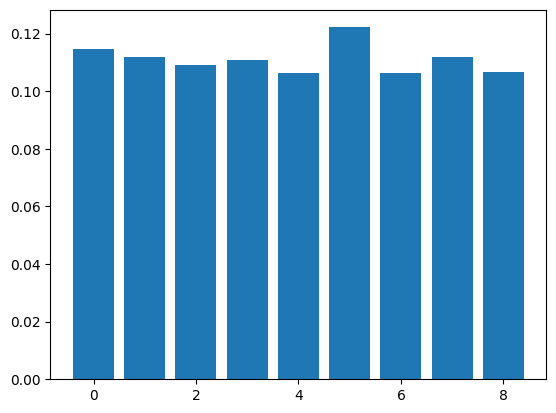

In [9]:
import matplotlib.pyplot as plt

model = resnet_tictactoe_policy()

policy, value = model(tensor_state)
print(tf.nn.softmax(policy).numpy())
print(value)

plt.bar(np.arange(9), tf.nn.softmax(policy).numpy()[0])
plt.show()

In [10]:
class AlphaZero:
  def __init__(self, model, optimizer, game, args):
    self.model = model
    self.optimizer = optimizer
    self.game = game
    self.args = args
    self.mcts = MCTS(game, args, model)

  def self_play(self):
    state = self.game.get_initial_state()
    memory = []
    player = 1

    while True:
      # Start the game as the neutral state
      neutral_state = self.game.change_perspective(state, player)
      # Do a search of the action space from the neutral state
      action_probs = self.mcts.search(neutral_state) # <------- ERROR

      # Add the states and the action probabilities to a memory
      memory.append((neutral_state, action_probs, player))

      # Choose the random action from the action space using probabilities from the model
      action = np.random.choice(self.game.action_space, p=action_probs)
      state = self.game.get_next_state(state, action, player)

      # Check whether game is over
      value, is_terminal = self.game.get_game_value(state, action)

      if is_terminal:
        returnMemory = []

        for hist_neutral_state, hist_action_probs, cplayer in memory:
          hist_outcome = value if cplayer == player else self.game.get_opponent_value(value)
          returnMemory.append((self.game.get_encoded_state(hist_neutral_state),
                              hist_action_probs,
                              hist_outcome))
        return returnMemory
      player = self.game.get_opponent(player)

  def train(self, memory):
    random.shuffle(memory)
    # Custom loop
    for batch_idx in range(0, len(memory), self.args['batch_size']):
      # Determine outcome relative to the player whose turn it was
      sample = memory[batch_idx:min(len(memory), batch_idx + self.args['batch_size'])]
      state, policy_targets, value_targets = zip(*sample)

      state, policy_targets, value_targets = np.array(state), np.array(policy_targets), np.array(value_targets)
      state = tf.constant(state, dtype=tf.float32) # <----- CHECK
      policy_targets = tf.constant(policy_targets, dtype=tf.float32)
      value_targets = tf.constant(value_targets, dtype=tf.float32)

      with tf.GradientTape() as tape:
        policy_preds, value_preds = self.model(state)
        policy_loss = tf.keras.losses.CategoricalCrossentropy()(policy_targets, policy_preds)
        value_loss = tf.keras.losses.MeanSquaredError()(value_targets, value_preds)
        total_loss = policy_loss + value_loss
        print(f'policy loss: {policy_loss.numpy()} value loss: {value_loss.numpy()} total loss: {total_loss}')

        grads = tape.gradient(total_loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))


  def learn(self):
    for iter in range(self.args['num_iterations']):
      memory = []

      for selfPlay_iter in trange(self.args['num_selfPlay_iterations']):
        memory += self.self_play()

      # train the model
      for epoch in trange(self.args['num_epochs']):
        self.train(memory)

      model_path = './model.h5'
      optimizer_path = './optimizer.h5'

    # Save the states
    model_path = f'./model_iter_{iter+1}.h5'
    tf.keras.models.save_model(self.model, filepath=model_path)
    #tf.keras.models.save_model(self.optimizer, filepath=optimizer_path)

In [12]:
tf.debugging.set_log_device_placement(True)


In [14]:
# NOTE: There are over 19000 configurations in the game
# of tictactoe so adjust he number of iterations and selfplay variables
# to suite

if __name__ == '__main__':

  tictactoe = TicTacToe()
  player = 1

  print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

  args = {
    'C': 2,
    'num_searches': 50,
    'num_iterations': 4,
    'num_selfPlay_iterations': 100,
    'num_epochs': 5,
    'batch_size': 64
  }


  model = resnet_tictactoe_policy()
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  alphaZero = AlphaZero(model, optimizer, tictactoe, args)
  alphaZero.learn()

Num GPUs Available:  1


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

policy loss: 2.2733662128448486 value loss: 0.6683832406997681 total loss: 2.9417495727539062
policy loss: 2.132643222808838 value loss: 0.4549907445907593 total loss: 2.5876340866088867
policy loss: 2.0258891582489014 value loss: 0.5145213007926941 total loss: 2.5404105186462402
policy loss: 1.890791893005371 value loss: 0.56203693151474 total loss: 2.452828884124756
policy loss: 1.8400111198425293 value loss: 0.3279522955417633 total loss: 2.1679635047912598
policy loss: 1.8070454597473145 value loss: 0.2429773211479187 total loss: 2.050022840499878
policy loss: 1.7266498804092407 value loss: 0.19039727747440338 total loss: 1.917047142982483
policy loss: 1.6344400644302368 value loss: 0.15648901462554932 total loss: 1.7909290790557861
policy loss: 1.5679550170898438 value loss: 0.1284138560295105 total loss: 1.696368932723999
policy loss: 1.4976171255111694 value loss: 0.13203103840351105 total loss: 1.629648208618164
policy loss: 1.4354994297027588 value loss: 0.06055501103401184 to

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

policy loss: 0.005637041293084621 value loss: 3.6441642805584706e-06 total loss: 0.005640685558319092
policy loss: 0.004066781140863895 value loss: 1.9601427538873395e-06 total loss: 0.004068741109222174
policy loss: 0.0038935155607759953 value loss: 2.527580363675952e-06 total loss: 0.0038960431702435017
policy loss: 0.003033696673810482 value loss: 1.2394882560329279e-06 total loss: 0.0030349362641572952
policy loss: 0.0025730940978974104 value loss: 2.4136675165209454e-06 total loss: 0.00257550785318017
policy loss: 0.0024845856241881847 value loss: 1.392410695189028e-06 total loss: 0.002485977951437235
policy loss: 0.0023361309431493282 value loss: 2.7210639927943703e-06 total loss: 0.002338852034881711
policy loss: 0.0020679724402725697 value loss: 1.907594878503005e-06 total loss: 0.002069880021736026
policy loss: 0.0017651752568781376 value loss: 1.8603927856020164e-06 total loss: 0.0017670356901362538
policy loss: 0.001439113519154489 value loss: 1.9232029444538057e-06 total lo

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

policy loss: 0.0003875981201417744 value loss: 8.409763836425554e-07 total loss: 0.0003884391044266522
policy loss: 0.0003827580367214978 value loss: 9.017671800393146e-07 total loss: 0.0003836597898043692
policy loss: 0.0003685400588437915 value loss: 7.059924200802925e-07 total loss: 0.00036924605956301093
policy loss: 0.0003993014106526971 value loss: 7.021496344350453e-07 total loss: 0.00040000356966629624
policy loss: 0.00035945198033005 value loss: 3.1668758992964285e-07 total loss: 0.0003597686591092497
policy loss: 0.0003855086397379637 value loss: 7.516595132983639e-07 total loss: 0.00038626030436716974
policy loss: 0.00032941054087132215 value loss: 3.7051074741611956e-07 total loss: 0.00032978106173686683
policy loss: 0.00036283215740695596 value loss: 7.32293187866162e-07 total loss: 0.00036356443888507783
policy loss: 0.000367153697879985 value loss: 7.246608788591402e-07 total loss: 0.0003678783541545272
policy loss: 0.0003527213411871344 value loss: 6.372669645315909e-07

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

policy loss: 0.00024087248311843723 value loss: 6.30544548130274e-07 total loss: 0.0002415030321571976
policy loss: 0.0002091679343720898 value loss: 2.9320341354832635e-07 total loss: 0.00020946114091202617
policy loss: 0.0002250900724902749 value loss: 5.720272611142718e-07 total loss: 0.00022566209372598678
policy loss: 0.00023396647884510458 value loss: 2.7887506348633906e-07 total loss: 0.000234245351748541
policy loss: 0.00022513934527523816 value loss: 3.488549964458798e-07 total loss: 0.0002254881983390078
policy loss: 0.00023237238929141313 value loss: 5.290486910780601e-07 total loss: 0.00023290143872145563
policy loss: 0.00022172555327415466 value loss: 4.4146264599476126e-07 total loss: 0.00022216701472643763
policy loss: 0.00021389895118772984 value loss: 3.1884695772532723e-07 total loss: 0.00021421779820229858
policy loss: 0.00020382429647725075 value loss: 3.0766207714805205e-07 total loss: 0.0002041319530690089
policy loss: 0.00020007544662803411 value loss: 3.52980492

policy loss: 0.0001685322349658236 value loss: 2.2548880451722653e-07 total loss: 0.00016875771689228714


In [16]:


mcts = MCTS(tictactoe, args, model)

state = tictactoe.get_initial_state()


while True:
    print(state)

    if player == 1:
        valid_moves = tictactoe.get_valid_moves(state)
        print("valid_moves", [i for i in range(tictactoe.row_count * tictactoe.column_count) if valid_moves[i] == 1])
        action = int(input(f"{player}:"))

        if valid_moves[action] == 0:
            print("action not valid")
            continue

    else:
        neutral_state = tictactoe.change_perspective(state, player)
        mcts_probs = mcts.search(neutral_state)
        action = np.argmax(mcts_probs)

    state = tictactoe.get_next_state(state, action, player)

    value, is_terminal = tictactoe.get_game_value(state, action)

    if is_terminal:
        print(state)
        if value == 1:
            print(player, "won")
        else:
            print("draw")
        break

    player = tictactoe.get_opponent(player)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
valid_moves [0, 1, 2, 3, 4, 5, 6, 7, 8]
1:0
[[1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[ 1.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0. -1.]]
valid_moves [1, 2, 3, 4, 5, 6, 7]
1:2
[[ 1.  0.  1.]
 [ 0.  0.  0.]
 [ 0.  0. -1.]]
[[ 1.  0.  1.]
 [ 0.  0.  0.]
 [ 0. -1. -1.]]
valid_moves [1, 3, 4, 5, 6]
1:3
[[ 1.  0.  1.]
 [ 1.  0.  0.]
 [ 0. -1. -1.]]
[[ 1.  0.  1.]
 [ 1.  0.  0.]
 [-1. -1. -1.]]
-1 won
